In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd

import copy
#import slugify

import keplergl
import matplotlib.pyplot as plt

In [3]:
dataset = pd.ExcelFile('/Users/oscaresbri/Downloads/煤电财务数据说明_financial data for coal power plants 20201104.xlsx')

In [4]:
dataset.sheet_names

['Readme',
 'Plant_New',
 'Plant_Operating',
 'Costs&Benefits',
 'Scenario_New',
 'Scenario_Operating',
 'Chinese_English_names and other']

In [5]:
new_dict = {'Province_chinese': 'province', 'Chinese name': 'plant_chi', 'Capacity': 'capacity',
           'Status': 'status', 'Year': 'year', 'Latitude': 'latitude', 'Longitude': 'longitude',
           'Combustion technology': 'comb_tech'}
op_dict = {'Country': 'country', 'Chinese name': 'plant_chi', 'Province': 'province', 'Capacity (MW)': 'capacity',
          'Year': 'year', 'Combustion technology': 'comb_tech', 'Latitude': 'latitude', 'Longitude': 'longitude',
          'Age': 'age', 'Plant': 'plant'}

plant_new = dataset.parse('Plant_New').rename(columns=new_dict)
plant_op = dataset.parse('Plant_Operating').rename(columns=op_dict)

In [6]:
plant_new['age'] = np.nan
plant_op['status'] = 'operational'

cols = ['latitude', 'longitude', 'plant', 'plant_chi', 'country', 'province', 'year', 'age', 
       'status', 'comb_tech', 'capacity']

plant_new = plant_new[cols]
plant_new = plant_new.drop_duplicates()
plant_op = plant_op[cols]

In [7]:
power_plants = pd.concat([plant_op, plant_new])
power_plants.reset_index(drop=True, inplace=True)
power_plants['plant'] = power_plants['plant'].fillna('No name')
power_plants['plant_chi'] = power_plants['plant_chi'].fillna('No name')

In [8]:
coben = dataset.parse('Costs&Benefits').fillna('000')

In [9]:
for col in coben.keys():
    if coben[col][0] == '000':
        if col.find('Unnam') > -1:
            coben[col][0] = coben[col][1]
        else:
            coben[col][0] = col

new_header = coben.iloc[0] #grab the first row for the header
new_header[0]= 'Plant_chi'
coben = coben[1:] #take the data less the header row
coben.columns = new_header
coben.drop(columns=['000'], inplace=True)
coben.drop(index=[1, 2], inplace=True)
coben.reset_index(drop=True, inplace=True)

<ipython-input-9-188a6ba95d0e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_header[0]= 'Plant_chi'


In [10]:
coben.columns = map(str.lower, coben.columns)
coben = coben.drop_duplicates()

In [11]:
coben['plant_chi'] = coben['plant_chi'].str.split("#", expand=False).str[-1].str.strip()

In [12]:
all_data = power_plants.set_index('plant_chi').join(coben.set_index('plant_chi'), rsuffix ='_cb')
for col in coben.keys()[1:-1]:
    all_data[col] = all_data[col].astype('float64')
all_data.drop_duplicates(inplace=True)

In [13]:
all_data.head()

,latitude,longitude,plant,country,province,year,age,status,comb_tech,capacity,...,welfare,fuel fee,tax,value added tax,urban construction tax and education surcharges,income tax,interest,long term loan interest,short term loan interest,plant_cb
plant_chi,,,,,,,,,,,,,,,,,,,,,
万华化学(烟台)氯碱热电公司,37.69589,121.062700,Yantai Wanhua Chlor-alkali Cogen power station,China,山东,NaN,NaN,construction,Subcritical,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
万基控股洛阳义安电力公司,34.74132,112.063412,No name,China,河南,2006.0,14.0,operational,Subcritical,135,...,8609.084640,77915.889318,66824.407948,41902.463613,2953.945418,21967.998917,19995.766958,19685.077349,310.689609,000
万基控股铝业自备电厂,34.74132,112.063412,Henan Xin'an power station,China,河南,2010.0,10.0,operational,Subcritical,300,...,9422.614032,152233.795894,106780.156992,68890.122300,4597.395756,33292.638936,37986.913352,37379.881091,607.032261,Henan Xin'an power station
万基控股铝业自备电厂,34.74132,112.063412,Henan Xin'an power station,China,河南,2010.0,10.0,operational,Subcritical,300,...,8842.356432,137851.826811,89755.736245,60020.425882,3864.664111,25870.646252,36394.404510,35844.720350,549.684159,Henan Xin'an power station
万基控股铝业自备电厂,34.74132,112.063412,Henan Xin'an power station,China,河南,2011.0,9.0,operational,Subcritical,300,...,9422.614032,152233.795894,106780.156992,68890.122300,4597.395756,33292.638936,37986.913352,37379.881091,607.032261,Henan Xin'an power station


In [14]:
all_data.reset_index(inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   plant_chi                                        2339 non-null   object 
 1   latitude                                         2338 non-null   float64
 2   longitude                                        2338 non-null   float64
 3   plant                                            2339 non-null   object 
 4   country                                          2339 non-null   object 
 5   province                                         2339 non-null   object 
 6   year                                             2198 non-null   float64
 7   age                                              2114 non-null   float64
 8   status                                           2339 non-null   object 
 9   comb_tech                     

In [17]:
all_data.to_csv('../data/plats_clean.csv')

In [30]:
#convert df to geodataframe
power_gdf = gpd.GeoDataFrame(
    all_data, geometry=gpd.points_from_xy(all_data.longitude, all_data.latitude))

In [31]:
power_gdf = power_gdf.set_crs(epsg=4326)

In [32]:
config = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "power plants"
          ],
          "id": "fb174vrp",
          "name": [
            "province"
          ],
          "type": "multiSelect",
          "value": [],
          "enlarged": False,
          "plotType": "histogram",
          "yAxis": None
        },
        {
          "dataId": [
            "power plants"
          ],
          "id": "yjtt6rroe",
          "name": [
            "status"
          ],
          "type": "multiSelect",
          "value": [],
          "enlarged": False,
          "plotType": "histogram",
          "yAxis": None
        },
        {
          "dataId": [
            "power plants"
          ],
          "id": "56le2ig2j",
          "name": [
            "comb_tech"
          ],
          "type": "multiSelect",
          "value": [],
          "enlarged": False,
          "plotType": "histogram",
          "yAxis": None
        }
      ],
      "layers": [
        {
          "id": "4vpvh2m",
          "type": "point",
          "config": {
            "dataId": "power plants",
            "label": "Power plants",
            "color": [
              136,
              87,
              44
            ],
            "columns": {
              "lat": "latitude",
              "lng": "longitude",
              "altitude": None
            },
            "isVisible": True,
            "visConfig": {
              "radius": 10,
              "fixedRadius": False,
              "opacity": 0.17,
              "outline": False,
              "thickness": 2,
              "strokeColor": None,
              "colorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ],
                "reversed": False
              },
              "strokeColorRange": {
                "name": "Global Warming",
                "type": "sequential",
                "category": "Uber",
                "colors": [
                  "#5A1846",
                  "#900C3F",
                  "#C70039",
                  "#E3611C",
                  "#F1920E",
                  "#FFC300"
                ]
              },
              "radiusRange": [
                0,
                62.8
              ],
              "filled": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "status",
              "type": "string"
            },
            "colorScale": "ordinal",
            "strokeColorField": None,
            "strokeColorScale": "quantile",
            "sizeField": {
              "name": "capacity",
              "type": "integer"
            },
            "sizeScale": "sqrt"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "power plants": [
              {
                "name": "plant_chi",
                "format": None
              },
              {
                "name": "plant",
                "format": None
              },
              {
                "name": "province",
                "format": None
              },
              {
                "name": "status",
                "format": None
              },
              {
                "name": "year",
                "format": None
              },
              {
                "name": "comb_tech",
                "format": None
              },
              {
                "name": "capacity",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 0,
      "dragRotate": False,
      "latitude": 34.38300085392487,
      "longitude": 108.20431461974995,
      "pitch": 0,
      "zoom": 3.4299923852172114,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {
        "border": True
      },
      "visibleLayerGroups": {
        "label": True,
        "road": False,
        "border": True,
        "building": False,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [33]:
#Filter by province, status, comb_tech
data_dict = {"power plants": power_gdf}
power_map = keplergl.KeplerGl(height=500, 
                                 data=data_dict, 
                                 config=config)
power_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['power plants'], 'id': 'fb17…

In [34]:
power_map.save_to_html?

In [35]:
#for some reason it needs to re-build the gdf before exporting...
power_gdf = gpd.GeoDataFrame(
    all_data, geometry=gpd.points_from_xy(all_data.longitude, all_data.latitude))
power_gdf = power_gdf.set_crs(epsg=4326)
power_map.save_to_html(data={"power plants": power_gdf}, config=config, file_name='power_map_161120.html')

Map saved to power_map_161120.html!


In [25]:
def get_chart(metrics = 'capacity', province=None, status=None, comb_tech=None, results = 30):
    filt_dic = {'metrics': metrics, 'province': province, 'status': status, 'comb_tech': comb_tech}
    new_df = power_gdf.copy()
    
    metrics_dic = {'capacity': ['capacity'],
                   'taxes': ['tax', 'value added tax', 'urban construction tax and education surcharges',
                           'income tax', 'interest', 'long term loan interest', 'short term loan interest'],
                   'op_maint': ['fuel fee', 'annual average operating cost', 'operation Costs',
                                'maintenance cost', 'insurance', 'wages', 'welfare'],
                   'const_upgr': ['construction costs', 'construction and installation cost',
                                  'labor cost of construction and installation', 'equipment purchase cost', 
                                  'other expenses'],
                   'rev': ['net value of fixed assets','annual average electricity sales revenue'],
                   'loan': ['remaining loan']}
                 
    for filt in filt_dic.keys():
            if filt_dic[filt]:
                if filt == 'metrics':
                    if filt_dic[filt] not in metrics_dic.keys():
                        raise ValueError(f"{filt} has to be one of {metrics_dic.keys()}")
                else:
                    if filt_dic[filt] not in new_df[filt].unique():
                        raise ValueError(f"{filt} has to be one of {new_df[filt].unique()}")
                    new_df = new_df[new_df[filt]==filt_dic[filt]]

    
    fig, axs = plt.subplots(figsize=(10, 10))
    new_cols = ['plant_chi', 'year', 'province', 'status']+metrics_dic[filt_dic['metrics']]
    new_df = new_df[new_cols]
    #new_df['total'] = new_df
    new_df.sort_values(by='capacity', ascending=False, inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    plot_df = new_df[:results]
    new_df['label'] = new_df['plant_chi'] + new_df['year'].astype(str) + new_df['province']
    axs.barh(plot_df['plant_chi'], plot_df['capacity'])
    axs.set_ylim(axs.get_ylim()[::-1])
    for filt in filt_dic.keys():
        if filt_dic[filt] == None:
            filt_dic[filt] = f"No {filt}"
    fig.suptitle(f"{filt_dic['province']}, {filt_dic['status']}, {filt_dic['comb_tech']}", size='xx-large')
    plt.show()
    return new_df

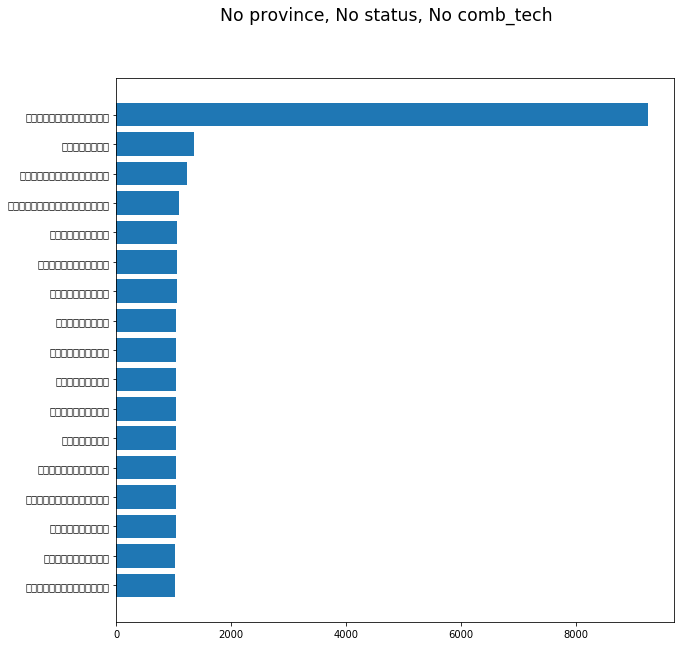

In [26]:
a = get_chart()

In [221]:
new_list = ['plant_chi']+tax

In [ ]:
capacity = ['capacity']


In [225]:
another_df = all_data[new_list]
another_df = another_df.sort_values(by=sum(['plant_chi')
another_df.reset_index(inplace=True)

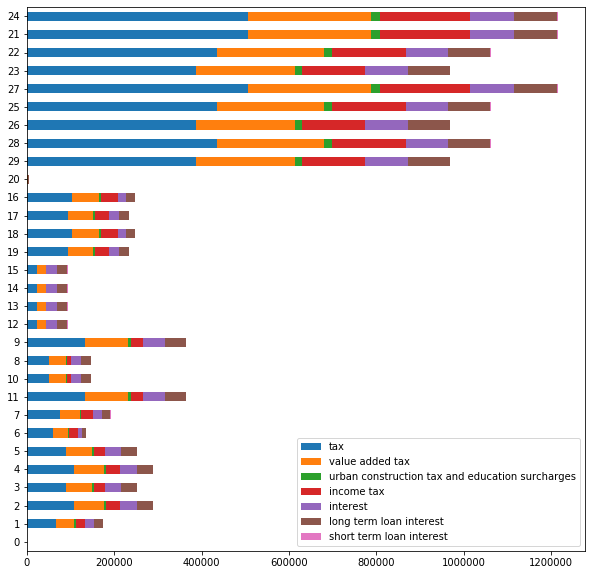

In [226]:
another_df[:30].plot(kind='barh', stacked=True, figsize=(10, 10))